--------------
# Playbook 5 : Capsule Network Test
--------------
This playbooks takes an existing Keras implementation of a capsule network (using Dynamic Routing) and tests it against MNIST, Fashion MNIST to ensure it accurate. It then looks at running it against a small flower data set (colour), to check if ita can train.

In all cases, I generate reconstruction images from the model, and compare with the original. This shows how the final capsule layer in the Capsule Network encodes an approximiate representation of class. 



## 1. Import required packages

In [0]:
# Like a great many other libraries in Python, Keras is a mess of incompatability. 
# Need to use 2.2.4 or it breaks the CapsNet Code. I therefore standardise on 
# keras and tensorflow versions
!pip install gast==0.3.2
!pip install keras==2.2.4
!pip install tensorflow==1.15.2

In [0]:
%tensorflow_version 1.15

import numpy as np
import keras as keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model

print(tf.__version__)
print(keras.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


1.15.2
2.2.4


##2. Define functions some utility functions for displaying images and model performance

In [0]:
import matplotlib.pyplot as plt
import math 

def showImgs(data, labels, num_imgs, cols=4, file=None):
    classes = len(np.unique(labels))
    rows = math.ceil(num_imgs * classes / cols + 0.5)

    fig = plt.figure(figsize=(cols * 1.5, rows * 1.5))
    img_num = 0
    index_num = 0
    for label in range(classes):
        for num in range(num_imgs):
            for index in range(index_num, len(labels)):         
                if label == labels[index]:
                    index_num = index + 1
                    pixels = data[index]
                    shape = pixels.shape
                    img_num += 1
                    f = fig.add_subplot(rows,cols,img_num)
                    f.set_title("Class %d"% label)
                    f.set_xticks([])
                    f.set_yticks([])
                    if len(shape) == 2 or shape[2] == 1:
                        plt.imshow(pixels[:,:,0], cmap='gray') 
                    else:
                        plt.imshow(pixels[:,:,::-1]) # BGR -> RGB
                    break

    plt.tight_layout()
    plt.show()
   
    if file is not None:
        fig.savefig(file)

def plotModelPerf(history, sup = None, file=None):
    # Plot model training and validation loss and accuracy on one graph
    # history is an object provided by a fit() operation on a model
    
    print("Plotting Model accuracy and loss versus epoch")

    length = len(history.history["loss"])
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(8,5))
    for key in history.history.keys():
        if 'caps' in key:
            plt.plot(np.arange(0, length), history.history[key], label=key)    

    if sup is None:
        plt.title("Training Loss and Accuracy", y = 1.05, fontsize=12)
    else:
        plt.title("Training Loss and Accuracy: ({})".format(sup), y = 1.05, fontsize=12)

    plt.xlabel("Epoch #") 
    plt.ylabel("Loss/Accuracy") 
    plt.legend()

    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

def showReconImages(in_imgs, out_imgs, shape, n=10, file = None):
    X, Y, CH = shape

    fig = plt.figure(figsize=(n*1.5, 2*1.5))

    for i in range(n):
        # display original
        f = fig.add_subplot(2, n, i+1)
        pixels = in_imgs[i].reshape(X, Y, CH)
        if len(shape) == 2 or shape[2] == 1:
            plt.imshow(pixels[:,:,0], cmap='gray') 
        else:
            plt.imshow(pixels[:,:,::-1]) # BGR -> RGB
        f.set_xticks([])
        f.set_yticks([])

        # display reconstruction
        f = fig.add_subplot(2, n, i+1 + n)
        pixels = out_imgs[i].reshape(X, Y, CH)
        if len(shape) == 2 or shape[2] == 1:
            plt.imshow(pixels[:,:,0], cmap='gray') 
        else:
            plt.imshow(pixels[:,:,::-1]) # BGR -> RGB
        f.set_xticks([])
        f.set_yticks([])
    
    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

##3 Define Capsule Network functions and classes
The following code is taken from 
* https://www.kaggle.com/kmader/capsulenet-on-mnist, 

This code, is in turn was based on the code by  Xifeng Guo at
* Author: Xifeng Guo, E-mail: guoxifeng1990@163.com, 
* Github: https://github.com/XifengGuo/CapsNet-Keras



In [0]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)


In [0]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
K.set_image_data_format('channels_last')

def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(np.prod(input_shape), activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=input_shape, name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

### 3.3 Function to generate and display reconstruction images from a CapsNet model 

In [0]:
def genCapsReconImgs(model, data, file=None):
    x_test, y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=x_test.shape[0])
    _, W, H, C = x_test.shape
    shape = (W, H, C)
    showReconImages(x_test, x_recon, shape, n=10, file=file)

##4. CapsNet on MNIST Digits

11493376/11490434 [==============================] - 0s 0us/step


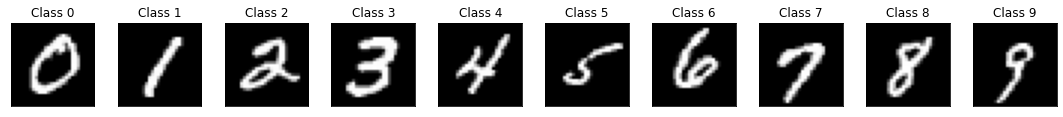

In [0]:
(train_X, train_Y), (test_X, test_Y) = tf.keras.datasets.mnist.load_data()
showImgs(train_X.reshape(-1, 28,28, 1), train_Y.reshape(-1, 1), 1, cols = 10, file="5_MNIST_samples.png")


In [0]:
train_X = train_X.reshape(-1, 784).astype('float32') / 255
train_Y = keras.utils.np_utils.to_categorical(train_Y)
test_X = test_X.reshape(-1, 784).astype('float32') / 255
test_Y = keras.utils.np_utils.to_categorical(test_Y)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [0]:
split_size = int(train_X.shape[0]*0.7)

train_X, val_X = train_X[:split_size], train_X[split_size:]
train_Y, val_Y = train_Y[:split_size], train_Y[split_size:]

train_x_r = train_X.reshape(-1, 28,28,1).astype('float32')
val_x_r = val_X.reshape(-1,28,28,1).astype('float32')
test_x_r = test_X.reshape(-1,28,28,1).astype('float32')
print(train_x_r.shape)
print(test_x_r.shape)

(42000, 28, 28, 1)
(10000, 28, 28, 1)


In [0]:
model = CapsNet(input_shape=[28, 28, 1],
                n_class=10,
                num_routing=3)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1152, 8)      0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
lambda_2 (

In [0]:
# compile the model
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss=[margin_loss, 'mse'],
              loss_weights=[1., 0.0005],
              metrics=['accuracy'])

In [0]:
def train_generator(x, y, batch_size, shift_fraction=0.0):
   train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                      height_shift_range=shift_fraction) 
   generator = train_datagen.flow(x, y, batch_size=batch_size)
   while 1:
     x_batch, y_batch = generator.next()
     yield ([x_batch, y_batch], [y_batch, x_batch])

In [0]:
history = model.fit_generator(generator=train_generator(train_x_r, train_Y, 128, 0.0),
                              validation_data=train_generator(val_x_r, val_Y, 128, 0.0),
                              validation_steps=int(val_Y.shape[0] / 128),
                              steps_per_epoch=int(train_Y.shape[0] / 128),
                              epochs=15)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/15





328/328 [==============================] - 157s 478ms/step - loss: 0.1037 - out_caps_loss: 0.1036 - out_recon_loss: 0.1631 - out_caps_acc: 0.8993 - out_recon_acc: 0.7430 - val_loss: 0.0278 - val_out_caps_loss: 0.0278 - val_out_recon_loss: 0.0677 - val_out_caps_acc: 0.9802 - val_out_recon_acc: 0.8040
Epoch 2/15
328/328 [==============================] - 141s 431ms/step - loss: 0.0214 - out_caps_loss: 0.0214 - out_recon_loss: 0.0671 - out_caps_acc: 0.9849 - out_recon_acc: 0.8035 - val_loss: 0.0174 - val_out_caps_loss: 0.0174 - val_out_recon_loss: 0.0657 - val_out_caps_acc: 0.9864 - val_out_recon_acc: 0.8043
Epoch 3/15
328/328 [==============================] - 141s 431ms/step - loss: 0.0148 - out_caps_loss: 0.0148 - out_recon_loss: 0.0653 - out_caps_acc: 0.9898 - out_recon_acc: 0.8043 - val_loss: 0.0162 - val_out_caps_loss: 0.0162 - val_out_recon_loss: 0.0636 - val_out_caps_ac

Plotting Model accuracy and loss versus epoch


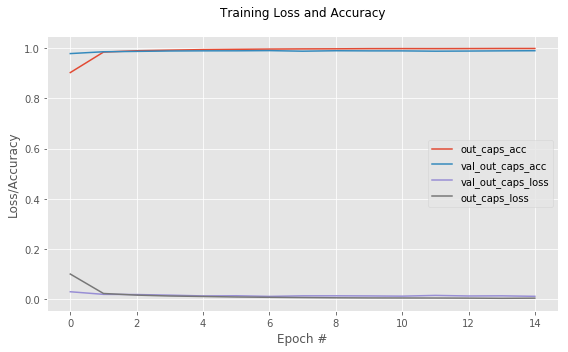

In [0]:
plotModelPerf(history, file="5_CAPS_MNIST_perf.png")

In [0]:
results = model.evaluate([test_x_r, test_Y], [test_Y, test_x_r]) 
print(results)
print("\nCapsnet Loss on Test set %.4f: Accuracy on Test set %.4f"% (results[1], results[3]))

10000/10000 [==============================] - 14s 1ms/step
[0.008757463194918819, 0.008730934901162982, 0.05305654044151306, 0.9926, 0.7939487255096436]

Capsnet Loss on Test set 0.0087: Accuracy on Test set 0.9926


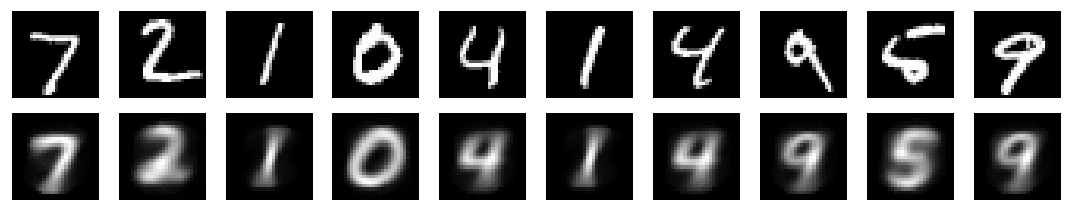

In [0]:
genCapsReconImgs(model=model, data=(test_x_r[:20], test_Y[:20]), file='5_CAPS_MNIST_recon.png')

## MNIST without using data generator

In [0]:
model2 = CapsNet(input_shape=[28, 28, 1],
                n_class=10,
                num_routing=3)

model2.compile(optimizer=keras.optimizers.Adam(lr=0.001),
               loss=[margin_loss, 'mse'],
               loss_weights=[1., 0.0005],
               metrics=['accuracy'])

history = model2.fit([train_x_r, train_Y], 
                     [train_Y, train_x_r], 
                     batch_size=128, 
                     epochs=15,
                     validation_data=[[val_x_r, val_Y], [val_Y, val_x_r]])

#5. Fashion MNIST

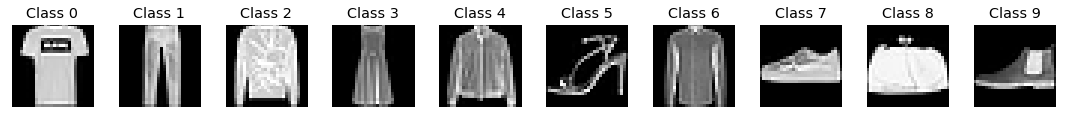

In [0]:
(train_X, train_Y), (test_X, test_Y) = tf.keras.datasets.fashion_mnist.load_data()
showImgs(train_X.reshape(-1, 28,28, 1), train_Y.reshape(-1, 1), 1, cols=10, file="5_FMNIST_samples.png")

In [0]:
train_X = train_X.reshape(-1, 784).astype('float32') / 255
train_Y = keras.utils.np_utils.to_categorical(train_Y)
test_X = test_X.reshape(-1, 784).astype('float32') / 255
test_Y = keras.utils.np_utils.to_categorical(test_Y)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [0]:
split_size = int(train_X.shape[0]*0.7)

train_X, val_X = train_X[:split_size], train_X[split_size:]
train_Y, val_Y = train_Y[:split_size], train_Y[split_size:]

In [0]:
train_x_r = train_X.reshape(-1, 28,28,1).astype('float32')
val_x_r = val_X.reshape(-1,28,28,1).astype('float32')
test_x_r = test_X.reshape(-1,28,28,1).astype('float32')
print(train_x_r.shape)
print(test_x_r.shape)

(42000, 28, 28, 1)
(10000, 28, 28, 1)


In [0]:
fmodel = CapsNet(input_shape=[28, 28, 1],
                n_class=10,
                num_routing=3)

fmodel.compile(optimizer=keras.optimizers.Adam(lr=0.001),
               loss=[margin_loss, 'mse'],
               loss_weights=[1., 0.0005],
               metrics=['accuracy'])

history = fmodel.fit([train_x_r, train_Y], 
                     [train_Y, train_x_r], 
                     batch_size=128, 
                     epochs=15,
                     validation_data=[[val_x_r, val_Y], [val_Y, val_x_r]])

(TensorShape([Dimension(None), Dimension(None), Dimension(8)]), TensorShape([Dimension(None), Dimension(None), Dimension(8)]))
Train on 42000 samples, validate on 18000 samples
Epoch 1/15
42000/42000 [==============================] - 145s 3ms/step - loss: 0.1778 - out_caps_loss: 0.1777 - out_recon_loss: 0.1443 - out_caps_acc: 0.7600 - out_recon_acc: 0.4401 - val_loss: 0.1139 - val_out_caps_loss: 0.1138 - val_out_recon_loss: 0.0871 - val_out_caps_acc: 0.8526 - val_out_recon_acc: 0.4887
Epoch 2/15
42000/42000 [==============================] - 142s 3ms/step - loss: 0.1032 - out_caps_loss: 0.1032 - out_recon_loss: 0.0845 - out_caps_acc: 0.8653 - out_recon_acc: 0.4915 - val_loss: 0.1013 - val_out_caps_loss: 0.1013 - val_out_recon_loss: 0.0819 - val_out_caps_acc: 0.8621 - val_out_recon_acc: 0.4911
Epoch 3/15
42000/42000 [==============================] - 143s 3ms/step - loss: 0.0899 - out_caps_loss: 0.0898 - out_recon_loss: 0.0764 - out_caps_acc: 0.8812 - out_recon_acc: 0.4952 - val_loss: 

Plotting Model accuracy and loss versus epoch


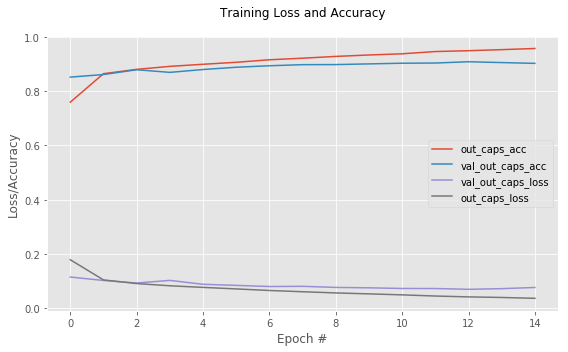

In [0]:
plotModelPerf(history, file="5_CAPS_FMNIST_perf.png")

In [0]:
results = fmodel.evaluate([test_x_r, test_Y], [test_Y, test_x_r]) 
print(results)
print("\nCapsnet Loss on Test set %.4f: Accuracy on Test set %.4f"% (results[1], results[3]))

10000/10000 [==============================] - 14s 1ms/step
[0.08090662364065647, 0.08088183484077453, 0.04957726532816887, 0.8964, 0.4949112241744995]

Capsnet Loss on Test set 0.0809: Accuracy on Test set 0.8964


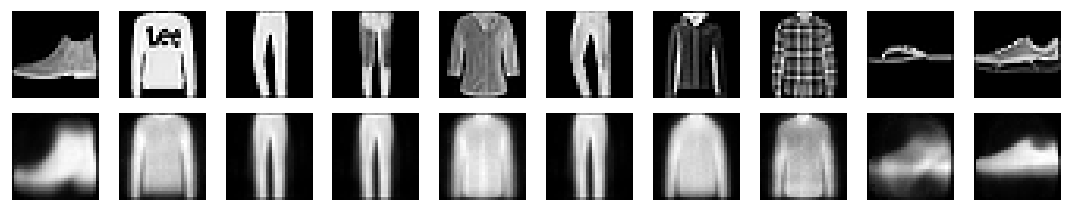

In [0]:
genCapsReconImgs(model=fmodel, data=(test_x_r[:20], test_Y[:20]), file='5_CAPS_FMNIST_recon.png')

##6. Flower data set 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

%env GPATH=/content/gdrive/My Drive/MSc AI/Project/msccode

%cp "$GPATH/Datasets/data1-2.h5.zip" "data1-2.h5.zip"
!unzip 'data1-2.h5.zip'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
env: GPATH=/content/gdrive/My Drive/MSc AI/Project/msccode
Archive:  data1-2.h5.zip
  inflating: data1.h5                


In [0]:
import h5py

def loadData():
    with h5py.File('data1.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        
        return trainX, trainY, valX, valY

In [0]:
print("Training data and label shape")
trainX, trainY, testX, testY = loadData()
print(trainX.shape, trainY.shape) 
print(testX.shape, testY.shape)

Training data and label shape
(1020, 128, 128, 3) (1020,)
(340, 128, 128, 3) (340,)


In [0]:
# Resize images
from skimage import transform

IMG_SIZE=32
CHANNELS=3
train_X = np.array([transform.resize(image, (IMG_SIZE, IMG_SIZE, CHANNELS)) for image in trainX])
test_X = np.array([transform.resize(image, (IMG_SIZE, IMG_SIZE, CHANNELS)) for image in testX])
test_Y = testY
train_Y = trainY
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

(1020, 32, 32, 3) (1020,)
(340, 32, 32, 3) (340,)


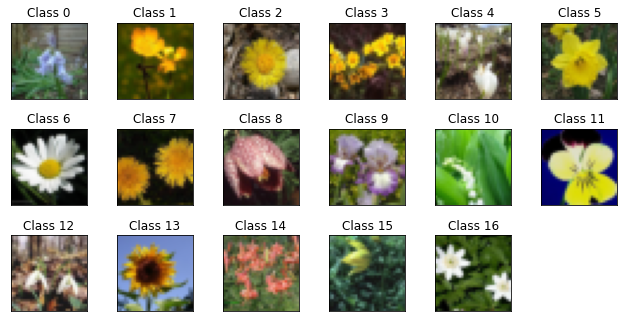

In [0]:
showImgs(train_X, train_Y, 1, cols=6, file="5_FLOWER_samples.png")

In [0]:
train_x_r = train_X
train_y_r = keras.utils.np_utils.to_categorical(train_Y)
test_x_r = test_X
test_y_r = keras.utils.np_utils.to_categorical(test_Y)
print(train_x_r.shape)
print(train_y_r.shape)
print(test_x_r.shape)
print(test_y_r.shape)

(1020, 32, 32, 3)
(1020, 17)
(340, 32, 32, 3)
(340, 17)


In [0]:
flmodel = CapsNet(input_shape=[IMG_SIZE, IMG_SIZE, CHANNELS],
                  n_class=len(np.unique(train_Y)),
                  num_routing=3)

flmodel.summary()

flmodel.compile(optimizer=keras.optimizers.Adam(lr=0.001),
               loss=[margin_loss, 'mse'],
               loss_weights=[1., 0.0005],
               metrics=['accuracy'])

history = flmodel.fit_generator(generator=train_generator(train_x_r, train_y_r, 128, 0.0),
                              validation_data=train_generator(test_x_r, test_y_r, 128, 0.0),
                              validation_steps=int(test_Y.shape[0] / 32),
                              steps_per_epoch=int(train_Y.shape[0] / 32),
                              epochs=30)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 256)  62464       input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 2048, 8)      0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
lambda_5 (

Plotting Model accuracy and loss versus epoch


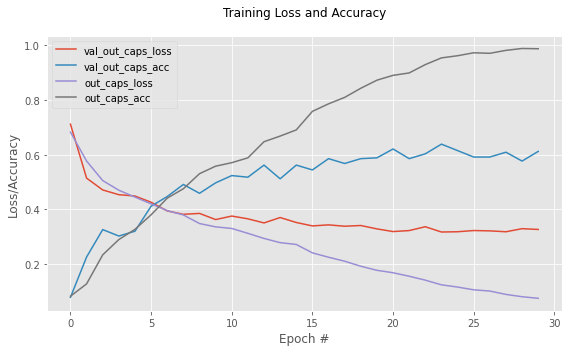

In [0]:
plotModelPerf(history, file="5_CAPS_Flower_perf.png")

In [0]:
results = flmodel.evaluate([test_x_r, test_y_r], [test_y_r, test_x_r]) 
print(results)
print("\nCapsnet Loss on Test set %.4f: Accuracy on Test set %.4f"% (results[1], results[3]))

340/340 [==============================] - 1s 3ms/step
[0.3518194671939401, 0.35178932547569275, 0.060282918197267193, 0.6117647072848151, 0.5089987348107731]

Capsnet Loss on Test set 0.3518: Accuracy on Test set 0.6118


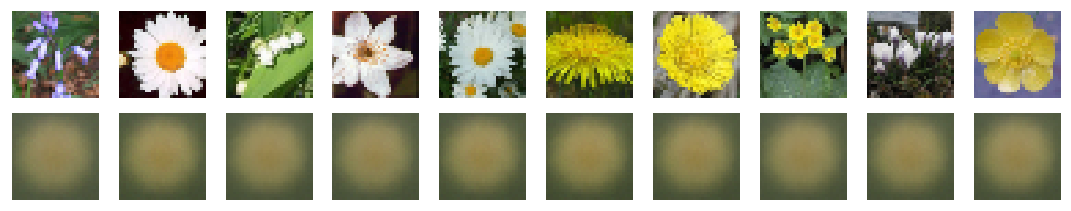

In [0]:
genCapsReconImgs(model=flmodel, data=(test_x_r[:12], test_y_r[:12]), file='5_CAPS_Flower_recon.png')

##7. Copy files to google drive

In [0]:
%%bash
cp -f ./*.h5 "$GPATH/Models"
cp -f ./*.json "$GPATH/Models"
cp -f ./*.pickle "$GPATH/Models"
cp -f ./*.png "$GPATH/Images"

cp: cannot stat './*.json': No such file or directory
cp: cannot stat './*.pickle': No such file or directory
